## Synthetic Mode Generation

This notebook shows how modes can be elaborated from health states in an fmdtools model.

In [1]:
import sys, os
sys.path.insert(0,os.path.join("..", ".."))

from fmdtools.modeldef import *
import fmdtools.resultdisp as rd
import fmdtools.faultsim.propagate as prop
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import multiprocessing as mp
import pandas as pd
import time

The Rover model is in defined rover_model.py, along with a few analysis methods.

In [3]:
from rover_model import Rover, gen_params, plot_map, plot_trajectories, compare_trajectories, plot_course

Below we compare the space of hazards revealed by querying the model with:
   - identifed modes (modes that we identify up-front)
   - elaborated modes (modes generated by lists of forseeable parameter values)
   - randomly-generated modes (modes generated by randomly sampling ranges of parameter values)

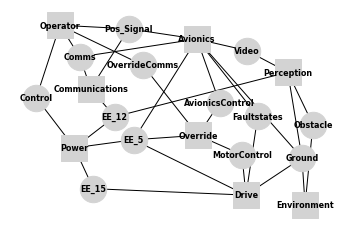

In [132]:
mdl_illust = Rover()
fig, ax = rd.graph.show(mdl_illust)
colors = ["goldenrod", "magenta", "blue"]

In [58]:
fig.savefig("rover_structure.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [133]:
fig.savefig("rover_structure.eps", format="eps", bbox_inches = 'tight', pad_inches = 0)

In [73]:
from mpl_toolkits.mplot3d import proj3d
def plot_hstate_modes(mdl, el_size=10, id_size=30, nom_size=50, el_alpha=1.0, mdl_range=[],
                      range_alpha=1.0, range_size=10, title = "Space of Fault Modes", colors=["yellow", "orange", "red", "blue"]):
    x= [hstates.get('friction', 0.0) for mode, hstates in mdl.fxns['Drive'].mode_state_dict.items()  if mode[:5]=='hmode']
    y= [hstates.get('transfer', 1.0) for mode, hstates in mdl.fxns['Drive'].mode_state_dict.items()  if mode[:5]=='hmode']
    z= [hstates.get('drift', 1.0) for mode, hstates in mdl.fxns['Drive'].mode_state_dict.items()  if mode[:5]=='hmode']
    
    x_id= [hstates.get('friction', 1.0) for mode, hstates in mdl.fxns['Drive'].mode_state_dict.items() if mode[:5]!='hmode']
    y_id= [hstates.get('transfer', 1.0) for mode, hstates in mdl.fxns['Drive'].mode_state_dict.items() if mode[:5]!='hmode']
    z_id= [hstates.get('drift', 0.0) for mode, hstates in mdl.fxns['Drive'].mode_state_dict.items() if mode[:5]!='hmode']
    id_labels= [mode for mode, hstates in mdl.fxns['Drive'].mode_state_dict.items() if mode[:5]!='hmode']
    
    fig = plt.figure()
    fig.patch.set_alpha(0.7)

    ax = fig.add_subplot(projection='3d')
    
    if mdl_range:
        x_r= [hstates.get('friction', 0.0) for mode, hstates in mdl_range.fxns['Drive'].mode_state_dict.items()  if mode[:5]=='hmode']
        y_r= [hstates.get('transfer', 1.0) for mode, hstates in mdl_range.fxns['Drive'].mode_state_dict.items()  if mode[:5]=='hmode']
        z_r= [hstates.get('drift', 1.0) for mode, hstates in mdl_range.fxns['Drive'].mode_state_dict.items()  if mode[:5]=='hmode']
        ax.scatter(x_r, y_r, z_r, label='range', color=colors[0], s=range_size, alpha=range_alpha)
    
    ax.scatter(x, y, z, label='set', color=colors[1], s=el_size, alpha=el_alpha)
    ax.scatter(x_id, y_id, z_id, label='identified', marker='X', color=colors[2], s=id_size, alpha=0.8)
    ax.scatter([1.0], [1.0], [0.0], label='nominal', marker='*', color=colors[3], s=nom_size)
    
    proj=ax.get_tightbbox(fig.canvas.get_renderer())
    
    ax2 = fig.add_subplot()
    ax2.patch.set_alpha(0.0)
    xmin, _, _ = proj3d.proj_transform(ax.get_xlim()[0], ax.get_ylim()[0], 0,  ax.get_proj())
    xmax, _, _ = proj3d.proj_transform(ax.get_xlim()[1], ax.get_ylim()[1], 0,  ax.get_proj())
    _, ymin, _ = proj3d.proj_transform(ax.get_xlim()[1], ax.get_ylim()[0], 0,  ax.get_proj())
    _, ymax, _ = proj3d.proj_transform(ax.get_xlim()[0], ax.get_ylim()[1], 0,  ax.get_proj())
    ylims = proj3d.proj_transform(ax.get_xlim()[0], ax.get_ylim()[1], 1,  ax.get_proj())
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(ymin-0.01, ymax+0.01)
    ax2.set_position((0.30, 0.3, 0.42, 0.4)) 
    plt.axis('off')
    #ax2.get_xaxis().set_visible(False)
    #ax2.get_yaxis().set_visible(False)
    for i, label in enumerate(id_labels):
        #ax.text(x_id[i], y_id[i], z_id[i], label, ha='left', va='bottom')
        xlab, ylab, _ = proj3d.proj_transform(x_id[i], y_id[i], z_id[i],  ax.get_proj())
        if label=='stuck_left': xyt=(-20,-30)
        elif label=='stuck': xyt=(20,-30)
        else: xyt=(20,30)
        plt.annotate(label, xy=(xlab, ylab), xytext=xyt, 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=1.0),
            arrowprops=dict(arrowstyle='-|>', color=colors[2]))
        #ax2.text(xlab, ylab, label, ha='left', va='bottom')
    ax.set_title(title)

    ax.set_xlabel('friction')
    ax.set_ylabel('transfer')
    ax.set_zlabel('drift')
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax2.legend(handles, labels, loc=(0.3,-0.2), framealpha=0.55, facecolor='white')
    ax2.get_legend().legendHandles[0]._sizes = [20]
    return fig

Below we compare the space of fault modes generated by our identified sets:

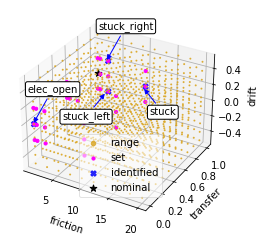

In [74]:
mdl_set = Rover(valparams={'drive_modes':'set-manual'})
mdl_range = Rover(valparams={'drive_modes':'range-manual-all'})
fig =plot_hstate_modes(mdl_set, mdl_range= mdl_range,range_alpha=0.8, range_size=1, title='', colors=colors+["black"])

In [75]:
len(mdl_range.fxns['Drive'].faultmodes)

1103

In [76]:
fig.savefig("hazard_space.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [77]:
fig.savefig("hazard_space.eps", format="eps", bbox_inches = 'tight', pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Below we look at how this results in different potential analyses...

This function plots the end distribution of a given attribue from the model endclasses.

In [184]:
def plot_enddist(endclasses, att='line_dist', range=(0,3), endclasses_range=[], density=False, yscale="log", 
                 fail_thresh=1.0, thresh_label="Off Course", x_lab="Line Distance", n_bins = 8,
                 title="Results Distributions Given From Approaches", colors=["yellow", "orange", "red"]):
    if endclasses_range:
        x_range_class = [endclass[att] for scen, endclass in endclasses_range.items() if scen[6:11]=='hmode']
        n,bins,patches = plt.hist(x_range_class, density=density, label='range', range=range, color=colors[0], bins=n_bins)
        x_elaborated_class = [endclass[att] for scen, endclass in endclasses.items() if scen[6:11]=='hmode']
        n,bins,patches = plt.hist(x_elaborated_class, density=density, alpha=0.8, label='set', range=range, bins=bins, color=colors[1])
    else:
        x_elaborated_class = [endclass[att] for scen, endclass in endclasses.items() if scen[6:11]=='hmode']
        n,bins,patches = plt.hist(x_elaborated_class, density=density, label='set', range=range, color=colors[1], bins=n_bins)
    
    if fail_thresh: plt.axvline(fail_thresh, label=thresh_label, color="black")
    
    x_identified_class = [endclass[att] for scen, endclass in endclasses.items() if scen[6:11]!='hmode' and scen!='nominal']
    label_identified_class = [scen[6:] for scen, endclass in endclasses.items() if scen[6:11]!='hmode'and scen!='nominal']
    
    _,_,_ = plt.hist(x_identified_class, density=density, alpha=0.8, bins=bins, label='identified', color=colors[2])
    plt.grid(axis='y', which='both')
    plt.legend()
    plt.yscale(yscale)
    if yscale=="log": plt.ylabel("# of Scens (log)")
    else:             plt.ylabel("Distribution")
    plt.xlabel(x_lab)
    plt.xlim(range)
    plt.title(title)
    return plt.gcf()

Finding phases so the Approach can inject the fault halfway through the simulation.

In [79]:
pool = mp.Pool(4)
endresults, mdlhist = prop.nominal(mdl_set)
phases, modephases = rd.process.modephases(mdlhist)

Simulating the set and range approach. Note that the identified modes are present in the range and mode approaches, so we end up taking this data from these results afterwards.

We simulate it here to get some idea of the simulation time.

In [173]:
t_id_0 = time.time()
mdl_id = Rover(valparams={'drive_modes':'manual'})
mdl_id.modelparams['use_end_condition']=False
app_id = SampleApproach(mdl_id, faults='Drive', phases={'drive':phases['Avionics']['drive']})
endclasses_id, mdlhists_id = prop.approach(mdl_id, app_id, staged=True, pool=pool)
t_id = time.time()-t_id_0
t_id

SCENARIOS COMPLETE: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 166.97it/s]


0.08479022979736328

In [81]:
t_set_0 = time.time()
app_set = SampleApproach(mdl_set, faults='Drive', phases={'drive':phases['Avionics']['drive']})
endclasses_set, mdlhists_set = prop.approach(mdl_set, app_set, staged=True, pool=pool)
t_set = time.time() - t_set_0
t_set

SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 150.30it/s]


0.3278653621673584

In [82]:
t_range_0 = time.time()
mdl_range = Rover(valparams={'drive_modes':'range-manual-all'})
mdl_range.modelparams['use_end_condition']=False
app_range = SampleApproach(mdl_range, faults='Drive', phases={'drive':phases['Avionics']['drive']})
endclasses_range, mdlhists_range = prop.approach(mdl_range, app_range, staged=True, pool=pool)
t_range = time.time() - t_range_0
t_range

SCENARIOS COMPLETE: 100%|██████████████████████████████████████████████████████████| 1103/1103 [00:13<00:00, 79.53it/s]


14.736895561218262

In [174]:
sim_times = [t_id, t_set, t_range]

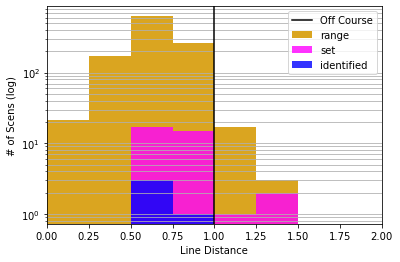

In [185]:
fig = plot_enddist(endclasses_set, endclasses_range=endclasses_range, range=(0,2), title='', colors=colors) #, colors = ['red','green','blue']

In [186]:
fig.savefig("line_dist.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [187]:
fig.savefig("line_dist.eps", format="eps", bbox_inches = 'tight', pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

as well as the discovery of fault trajectories...

In [136]:
def plot_course(hist,  nom_lab="Nominal", bound_lab="Bounds", center_lab="Center-line", nom_color="black"):

    plt.plot(hist['flows']['Ground']['x'],hist['flows']['Ground']['y'], color=nom_color)
    plt.scatter(hist['flows']['Ground']['x'][-1],hist['flows']['Ground']['y'][-1], color=nom_color, marker='*', label=nom_lab)

    x_ground = hist['flows']['Ground']['lbx']
    y_ground = hist['flows']['Ground']['lby']
    plt.plot(x_ground,y_ground, label=bound_lab, color='grey')
    x_ground = hist['flows']['Ground']['ubx']
    y_ground = hist['flows']['Ground']['uby']
    plt.plot(x_ground,y_ground, label=bound_lab, color='grey')
    x_ground = hist['flows']['Ground']['x']
    y_ground = hist['flows']['Ground']['liney']
    plt.plot(x_ground,y_ground, label=center_lab, color='grey', linestyle='--')

def plot_trajectories(mdlhists, nomhist=[],  app= [], faultlabel='Faulty', faultalpha=0.1, range_hist={}, rangealpha=0.1, 
                      setalpha=0.3, show_labels=True, title="Fault Trajectories", textoffset=2.0,mode_trunc=5,mode_trunc_end=5,
                      xlim=None, ylim=None, colors=["yellow", "orange", "red"]):
    in_mdlhists=False
    for mode, hist in range_hist.items():
        if mode[6:11]=='hmode':
            plt.plot(hist['flows']['Ground']['x'],hist['flows']['Ground']['y'], color=colors[0], alpha=rangealpha)
            plt.scatter(hist['flows']['Ground']['x'][-1],hist['flows']['Ground']['y'][-1], color=colors[0], alpha=rangealpha, marker='o', label='Range')
    for mode, hist in mdlhists.items():
        if mode=='nominal':
            plot_course(hist, nom_lab="_nolegend_")
            in_mdlhists=True
        elif mode[6:11]=='hmode':
            plt.plot(hist['flows']['Ground']['x'],hist['flows']['Ground']['y'], color=colors[1], alpha=setalpha)
            plt.scatter(hist['flows']['Ground']['x'][-1],hist['flows']['Ground']['y'][-1], color=colors[1], alpha=setalpha, marker='o', label='Set')
        else:
            plt.plot(hist['flows']['Ground']['x'],hist['flows']['Ground']['y'], color=colors[2], alpha=faultalpha)
            plt.scatter(hist['flows']['Ground']['x'][-1],hist['flows']['Ground']['y'][-1], color=colors[2], alpha=faultalpha, marker='*', label=faultlabel)
            if show_labels:
                label = mode[mode_trunc:]
                label = label[:-mode_trunc_end]
                randang = np.pi*np.random.rand()
                if 'stuck_left' in mode : xyt = textoffset * np.array([-0.5,1.5])
                elif 'stuck_right' in mode: xyt = textoffset * np.array([0.5,-1.5])
                elif 'elec_open' in mode: xyt = textoffset * np.array([-2,0.5])
                elif 'stuck' in mode: xyt = textoffset * np.array([1,-1])
                else: xyt = textoffset * np.array([-1,1])
                plt.annotate(label, xy=(hist['flows']['Ground']['x'][-1],hist['flows']['Ground']['y'][-1]), fontsize=8, 
                             xytext=xyt, textcoords='offset points', ha='center', va='bottom',
                             bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=1.0),
                             arrowprops=dict(arrowstyle='-|>', color='red'))        
    if app: plt.scatter(hist['flows']['Ground']['x'][app.times[0]],hist['flows']['Ground']['y'][app.times[0]], color='black', marker='X', label='fault time')
    if not in_mdlhists and nomhist: plot_course(nomhist)
    if xlim: plt.xlim(*xlim)
    if ylim: plt.ylim(*ylim)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title(title)
    plt.xlabel("x-distance (m)")
    plt.ylabel("y-distance (m)")
    plt.grid()
    return plt.gcf()

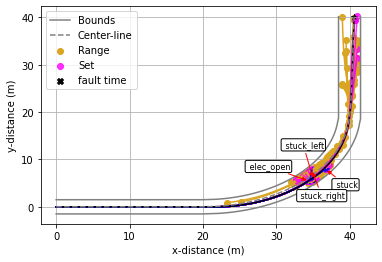

In [137]:
fig = plot_trajectories(mdlhists_set, mdlhist, app_range, range_hist=mdlhists_range, faultalpha=1.0, mode_trunc_end=6,
                        setalpha=0.8, rangealpha=1.0, title='', textoffset=20, colors=colors, faultlabel="_nolegend_")

In [138]:
fig.savefig("fault_map.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [139]:
fig.savefig("fault_map.eps", format="eps", bbox_inches = 'tight', pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

## Cluster Analysis

Below, we use clustering to identify similar sets of synthetic modes.

In [140]:
from sklearn.cluster import DBSCAN as cluster #DBSCAN

To find similar trajectories, we will cluster on the x-y coordinates of the end position of the Rover accross these scenarios:

In [141]:
X_range = np.array([[hist['flows']['Ground']['x'][-1],hist['flows']['Ground']['y'][-1]] for scen, hist in mdlhists_range.items() if 'hmode' in scen])
ec_range = [endclass['line_dist'] for scen, endclass in endclasses_range.items() if scen[6:11]=='hmode']

In [142]:
X_set = np.array([[hist['flows']['Ground']['x'][-1], hist['flows']['Ground']['y'][-1]] for scen, hist in mdlhists_set.items() if 'hmode' in scen])
ec_set = [endclass['line_dist'] for scen, endclass in endclasses_set.items() if scen[6:11]=='hmode']

In [143]:
X_id = np.array([[hist['flows']['Ground']['x'][-1],hist['flows']['Ground']['y'][-1]] for scen, hist in mdlhists_set.items()if 'hmode' not in scen])
ec_id = [endclass['line_dist'] for scen, endclass in endclasses_set.items() if scen[6:11]!='hmode' and scen[6:11]!='nominal']

To identify where all the clusters are accross all three approaches, we first have to combine the three sets of data into one (otherwise it might cluster differently).

In [144]:
X = np.concatenate((X_range, X_set, X_id))

This runs the clustering algorithm:

In [145]:
cl = cluster().fit(X)
labels = cl.labels_

The number of clusters is:

In [146]:
unique_labels = set(labels)
len(unique_labels)- (1 if -1 in labels else 0)

4

Here we plot the clusters on the course map to see what the algorithm identified.

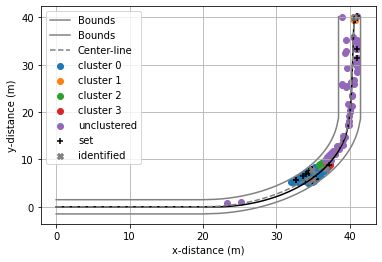

In [147]:
plot_course(mdlhist, nom_lab="_nolegend_")
clust_colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, clust_colors):
    x_label = [x[0] for i,x in enumerate(X) if labels[i]==k]
    y_label = [x[1] for i,x in enumerate(X) if labels[i]==k]
    if k == -1: clust_lab = 'unclustered'
    else:       clust_lab = 'cluster '+str(k)
    plt.scatter(x_label, y_label, label=clust_lab) 

plt.scatter(X_set[:,0],X_set[:,1], label='set', color='black', marker='+') 

plt.scatter(X_id[:,0],X_id[:,1], label='identified', color='gray', marker='X')  

plt.grid()
plt.xlabel('x-distance (m)')
plt.ylabel('y-distance (m)')

plt.legend()
fig = plt.gcf()

In [148]:
fig.savefig("cluster_map.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [149]:
fig.savefig("cluster_map.eps", format="pdf", bbox_inches = 'tight', pad_inches = 0)

Next, we would like to see how these approaches span the different clusters. If an approach has more coverage, we might say that it better explored the space.

In [150]:
categorizations = {tuple(x):labels[i] for i,x in enumerate(X)}

In [151]:
cat_values = {lab:{tuple(x) for x in X if lab==categorizations[tuple(x)]} for lab in set(labels)}

These are the categories found by each approach:

In [152]:
cat_range = [categorizations[tuple(x)] for x in X_range]
set(cat_range)

{-1, 0, 1, 2, 3}

In [153]:
cat_id = [categorizations[tuple(x)] for x in X_id]
set(cat_id)

{0, 1}

In [154]:
cat_set = [categorizations[tuple(x)] for x in X_set]
set(cat_set)

{-1, 0, 1, 3}

This function categorizes the results of each approach into the given clusters

In [155]:
def get_cats(categorizations, X, ec, unique_categorizations):
    cats={}
    for cat in unique_categorizations:
        cats[cat] = [ec[i] for i,x in enumerate(X) if categorizations[tuple(x)]==cat]+[0]
    return cats

In [156]:
cats = get_cats(categorizations,X_range, ec_range, unique_labels)

In [157]:
def worst_cat(categorizations, X, ec, unique_categorizations):
    worst_cats={}
    for cat in unique_categorizations:
        cats = [ec[i] for i,x in enumerate(X) if categorizations[tuple(x)]==cat]+[0]
        worst_cats[cat] = np.max(cats)
    return worst_cats

In [158]:
worst_cat_id = worst_cat(categorizations,X_id, ec_id, unique_labels)
worst_cat_range = worst_cat(categorizations,X_range, ec_range, unique_labels)
worst_cat_set = worst_cat(categorizations,X_set, ec_set, unique_labels)

This table shows the worst-case identified in each category

In [159]:
cat_tab = pd.DataFrame([[*worst_cat_id.values()], [*worst_cat_set.values()], [*worst_cat_range.values()]], index = ["Identified", "Set", "Range"], columns = worst_cat_id.keys())
cat_tab

,0,1,2,3,-1
Identified,0.758834,0.629957,0.000000,0.000000,0.000000
Set,0.984059,0.973689,0.000000,0.612927,1.452472
Range,1.050575,1.010028,0.722271,0.633112,1.407741


To view the coverage of each approach, here we plot the frequency of scenarios accross the clusters.

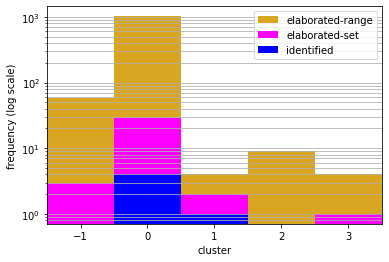

In [181]:
fig, ax = plt.subplots()
bins=np.array([-1,0,1,2,3,4])-0.5
ax.hist(cat_range, bins, label='elaborated-range', color=colors[0])
ax.hist(cat_set, bins, label='elaborated-set', color=colors[1])
ax.hist(cat_id, bins, label='identified', color=colors[2])
ax.set_xticks(bins + 0.5)
ax.set_xlim(-1.5,3.5)
ax.set_yscale("log")
ax.grid(axis='y', which='both')
ax.set_xlabel("cluster")
ax.set_ylabel("frequency (log scale)")
ax.legend()

In [182]:
fig.savefig("cluster_dist.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [183]:
fig.savefig("cluster_dist.eps", format="eps", bbox_inches = 'tight', pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Next, summarizing the overall stats from the approaches:

In [162]:
uncat_range = sum([i==-1 for i in cat_range])
uncat_set = sum([i==-1 for i in cat_set])
uncat_id = sum([i==-1 for i in cat_id])

In [163]:
uncat = [uncat_id, uncat_set, uncat_range]
lens = [len(X_id), len(X_set), len(X_range)]
num_cat = 100*np.array([len(set(cat_id))/len(unique_labels),len(set(cat_set))/len(unique_labels),len(set(cat_range))/len(unique_labels)])

In [175]:
res_tab = pd.DataFrame([lens, sim_times,num_cat, uncat])
res_tab.columns=['Identified', 'Elaborated-Set', 'Elaborated-Range']
res_tab.index=["Scenarios","Comp. Time (s)", "% Clusters", "Unclustered"]
res_tab

,Identified,Elaborated-Set,Elaborated-Range
Scenarios,5.00000,35.000000,1099.000000
Comp. Time (s),0.08479,0.327865,14.736896
% Clusters,40.00000,80.000000,100.000000
Unclustered,0.00000,3.000000,59.000000


In [176]:
print(res_tab.to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
{} &  Identified &  Elaborated-Set &  Elaborated-Range \\
\midrule
Scenarios      &        5.00 &           35.00 &           1099.00 \\
Comp. Time (s) &        0.08 &            0.33 &             14.74 \\
\% Clusters     &       40.00 &           80.00 &            100.00 \\
Unclustered    &        0.00 &            3.00 &             59.00 \\
\bottomrule
\end{tabular}



Finally, we use the following to calculate more detailed statistics about the cluster coverage.

In [166]:
def calc_2d_cov_loss(xmin, xmax, ymin, ymax, xs, ys):
    return calc_coverage_loss(xmin, xmax, xs)*calc_coverage_loss(ymin, ymax, ys)
def calc_coverage_loss(xmin, xmax, xs):
    if xs:
        return (xmax-np.max(xs)+np.min(xs)-xmin)/(xmax-xmin)
    else: 
        return  (xmax-xmin)/(xmax-xmin)
def get_xs_ys(values, X_type):
    return [v[0] for v in values if v in X_type], [v[1] for v in values if v in X_type]

In [167]:
cov_loss_id,cov_loss_set,cov_loss_range = [],[],[]
num_scens_id,num_scens_set,num_scens_range = [],[],[]
for cat, values in cat_values.items():
    xs = [v[0] for v in values]
    ys = [v[1] for v in values]
    xs_id, ys_id = get_xs_ys(values, X_id)
    xs_set, ys_set = get_xs_ys(values, X_set)
    xs_range, ys_range = get_xs_ys(values, X_range)
    xmin,xmax,ymin,ymax = np.min(xs), np.max(xs), np.min(ys), np.max(ys)
    
    cov_loss_id.append(calc_2d_cov_loss(xmin,xmax,ymin,ymax ,xs_id,ys_id))
    cov_loss_set.append(calc_2d_cov_loss(xmin,xmax,ymin,ymax ,xs_set,ys_set))
    cov_loss_range.append(calc_2d_cov_loss(xmin,xmax,ymin,ymax, xs_range,ys_range))
    
    num_scens_id.append(len(xs_id));num_scens_set.append(len(xs_set));num_scens_range.append(len(xs_range))

Coverage Compared to the range approach:

In [168]:
cov_tab = pd.DataFrame([cov_loss_id,cov_loss_set,cov_loss_range], columns=list(cat_values.keys()), index = ["Identified", "Set", "Range"])

cov_tab

,0,1,2,3,-1
Identified,0.132563,1.000000,1.0,1.0,1.000000
Set,0.046339,0.784922,1.0,1.0,0.776659
Range,0.000000,0.146115,0.0,0.0,0.000002


Number of scenarios per approach for each cluster:

In [169]:
scens_tab = pd.DataFrame([num_scens_id,num_scens_set,num_scens_range], columns=list(cat_values.keys()), index = ["Identified", "Set", "Range"], dtype=int)

scens_tab

,0,1,2,3,-1
Identified,4,1,0,0,0
Set,18,2,0,1,3
Range,914,4,9,4,59


In [170]:
len(cat_values[0])

931

Combined Table:

In [171]:
comb = pd.concat({"# Scenarios":scens_tab, "Coverage Loss":cov_tab, "Worst-Case":cat_tab}, axis="columns",join='inner')
comb = comb.swaplevel(0, axis="columns")
#index = pd.MultiIndex.from_tuples(comb.columns)
#comb = comb.reindex(index, axis="columns")
comb = comb.sort_index(axis="columns")
comb = comb.T

comb_2 = pd.DataFrame(columns = comb.columns)
for i, ind in enumerate(comb.index):
    if not(i%3): comb_2 = comb_2.append(comb.iloc[i].astype(int)) 
    else: comb_2 = comb_2.append(comb.iloc[i].map('{:,.2f}'.format))
comb_2.index = comb.index
comb=comb_2
comb

Identified   Set Range
-1 # Scenarios            0     3    59
   Coverage Loss       1.00  0.78  0.00
   Worst-Case          0.00  1.45  1.41
 0 # Scenarios            4    18   914
   Coverage Loss       0.13  0.05  0.00
   Worst-Case          0.76  0.98  1.05
 1 # Scenarios            1     2     4
   Coverage Loss       1.00  0.78  0.15
   Worst-Case          0.63  0.97  1.01
 2 # Scenarios            0     0     9
   Coverage Loss       1.00  1.00  0.00
   Worst-Case          0.00  0.00  0.72
 3 # Scenarios            0     1     4
   Coverage Loss       1.00  1.00  0.00
   Worst-Case          0.00  0.61  0.63

In [172]:
print(comb.to_latex( ))

\begin{tabular}{lllll}
\toprule
   &            & Identified &   Set & Range \\
\midrule
-1 & \# Scenarios &          0 &     3 &    59 \\
   & Coverage Loss &       1.00 &  0.78 &  0.00 \\
   & Worst-Case &       0.00 &  1.45 &  1.41 \\
 0 & \# Scenarios &          4 &    18 &   914 \\
   & Coverage Loss &       0.13 &  0.05 &  0.00 \\
   & Worst-Case &       0.76 &  0.98 &  1.05 \\
 1 & \# Scenarios &          1 &     2 &     4 \\
   & Coverage Loss &       1.00 &  0.78 &  0.15 \\
   & Worst-Case &       0.63 &  0.97 &  1.01 \\
 2 & \# Scenarios &          0 &     0 &     9 \\
   & Coverage Loss &       1.00 &  1.00 &  0.00 \\
   & Worst-Case &       0.00 &  0.00 &  0.72 \\
 3 & \# Scenarios &          0 &     1 &     4 \\
   & Coverage Loss &       1.00 &  1.00 &  0.00 \\
   & Worst-Case &       0.00 &  0.61 &  0.63 \\
\bottomrule
\end{tabular}

